# CSCI 3360: Simple Sentiment Analysis
In this assignment, you are going to do a sentiment analysis on the Amazon review dataset using a Naive Bayes model. The task of  sentiment analysis involves lots of concepts and techniques from **natural language processing (NLP)**, but here we're going to  use the simplest model and take very _naive_ approach.
For this task, you will need to
- prepare and clean text data,
- preprocess the data to remove information irrelevant to our task,
- extract feature vectors from review texts (using bag-of-words model), and
- train a naive bayes model to classify positive and negative reviews

## Preparing the Amazon Instant Video Review Data
For this assignment, we're going to use the amazon instant video review data, which can be downloaded from [here](http://cs.uga.edu/~jwlee/teaching/csci3360/dataset/Amazon_Instant_Video_5.json). Your first task is to implement a function that load the dataset (in .json format) into your computer's memory. You can use any function you would like to use for loading the .json file, but I recommend to use the pandas as it's simple and convenient. Let's start by loading the libraries we'll be using.

# README: 

Using the most recent versions of these libraries for python 2.7

  anaconda:  4.2.0-np111py27_0  --> custom-py27_0     
    conda:     4.3.16-py27_0     
    pandas:    0.19.2-np111py27_1
    pyopenssl: 16.2.0-py27_0     
    requests:  2.13.0-py27_0  

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import bs4 as bs
import urllib2
import string
import numpy as np
import nltk
import json
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [32]:
url = 'http://cobweb.cs.uga.edu/~jwlee/teaching/csci3360/dataset/Amazon_Instant_Video_5.json'
f = urllib2.urlopen(url)

# read individual json objects from site & separate by newlines
data = f.read().split("\n")

# last elem in list is empty
data = data[:-1]

json_list = []
for line in data:
    json_list.append(json.loads(line))
                       
df = pd.DataFrame(json_list)
print df.head()

         asin helpful  overall  \
0  B000H00VBQ  [0, 0]      2.0   
1  B000H00VBQ  [0, 0]      5.0   
2  B000H00VBQ  [0, 1]      1.0   
3  B000H00VBQ  [0, 0]      4.0   
4  B000H00VBQ  [1, 1]      5.0   

                                          reviewText   reviewTime  \
0  I had big expectations because I love English ...   05 3, 2014   
1  I highly recommend this series. It is a must f...   09 3, 2012   
2  This one is a real snoozer. Don't believe anyt...  10 16, 2013   
3  Mysteries are interesting.  The tension betwee...  10 30, 2013   
4  This show always is excellent, as far as briti...  02 11, 2009   

       reviewerID                    reviewerName  \
0  A11N155CW1UV02                        AdrianaM   
1  A3BC8O2KCL29V2                         Carol T   
2   A60D5HQFOTSOM  Daniel Cooper "dancoopermedia"   
3  A1RJPIGRSNX4PW                  J. Kaplan "JJ"   
4  A16XRPF40679KG                   Michael Dobey   

                          summary  unixReviewTime  
0      A 

If you have successfully loaded the dataset, you will notice that the dataset contains the following fields:
- asin
- helpful
- overall
- reviewText
- reviewTime
- reviewerID
- reviewerName
- summary
- unixReviewTime

Among the above attributes, we will only use two of them: __overall__ and __reviewText__. Remove all other attributes except the two.

In [33]:
##########################################################
# remove all the columns except reviewText and overall   #
##########################################################

df = df.drop(['reviewerID','asin','reviewerName','helpful','summary','unixReviewTime','reviewTime'],axis=1)
print df.head()


   overall                                         reviewText
0      2.0  I had big expectations because I love English ...
1      5.0  I highly recommend this series. It is a must f...
2      1.0  This one is a real snoozer. Don't believe anyt...
3      4.0  Mysteries are interesting.  The tension betwee...
4      5.0  This show always is excellent, as far as briti...


F.Y.I., here's the distribution of overall ratings.

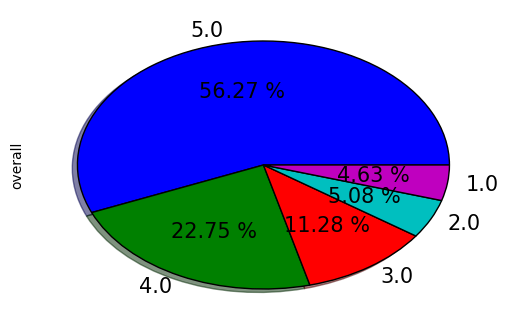

In [34]:
rating_cnt = df['overall'].value_counts()
rating_cnt.plot(kind='pie', shadow=True, autopct='%.2f %%', fontsize=15)
plt.show()

**Generate a label $Y_i$ for the $i^{\text{th}}$ review as follows**:
$$
Y_i = 
\begin{cases}
0 & \mbox{ if overall < 4,} \\
1 & \mbox{ if overall $\geq$ 4.}
\end{cases}
$$

In [35]:
# creating a label for each review in the dataset
###########################################
#        your code goes here              #
###########################################
#print df.iloc['overall']
df['label'] = np.where(df['overall'] < 4, 0, 1)

print df.head()

   overall                                         reviewText  label
0      2.0  I had big expectations because I love English ...      0
1      5.0  I highly recommend this series. It is a must f...      1
2      1.0  This one is a real snoozer. Don't believe anyt...      0
3      4.0  Mysteries are interesting.  The tension betwee...      1
4      5.0  This show always is excellent, as far as briti...      1


## Preprocessing the data

### Removing stop words
To remove the [stop words](https://en.wikipedia.org/wiki/Stop_words), we will use the **natural language toolkit (NLTK)**. See [here](http://www.nltk.org) for details. There is a pre-defined list of stop words for english. You can load it using the following code. You may need to download the resource that contains the pre-defined stop words.

~~~~
import nltk

nltk.download()
~~~~

In [36]:
import nltk
#nltk.download()
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
print stop_words


set([u'all', u'just', u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'o', u'hadn', u'herself', u'll', u'had', u'should', u'to', u'only', u'won', u'under', u'ours', u'has', u'do', u'them', u'his', u'very', u'they', u'not', u'during', u'now', u'him', u'nor', u'd', u'did', u'didn', u'this', u'she', u'each', u'further', u'where', u'few', u'because', u'doing', u'some', u'hasn', u'are', u'our', u'ourselves', u'out', u'what', u'for', u'while', u're', u'does', u'above', u'between', u'mustn', u't', u'be', u'we', u'who', u'were', u'here', u'shouldn', u'hers', u'by', u'on', u'about', u'couldn', u'of', u'against', u's', u'isn', u'or', u'own', u'into', u'yourself', u'down', u'mightn', u'wasn', u'your', u'from', u'her', u'their', u'aren', u'there', u'been', u'whom', u'too', u'wouldn', u'themselves', u'weren', u'was', u'until', u'more', u'himself', u'that', u'but', u'don', u'with', u'than', u'those', u'he', u'me', u'myself', u'ma', u'these', u'up', u'will', u'below', u'ain

Here's a list of pre-preprocessing we will be applying to our data.
1. **lowercase the review texts** (notice that all the stop words in NLTK's list is in lowercase)
2. **remove all the stop words** 
3. **apply the Porter stemming** algorithm (See [here](https://pythonprogramming.net/stemming-nltk-tutorial/) for an example)

Using the set of stop words defined in NLTK, filter out all the stop words in our review data. Also, remove all words whose length is smaller than 3 as they are not very informative. See [here](https://pythonprogramming.net/stop-words-nltk-tutorial/) for how to remove stop words using nltk.

In [37]:
# all review text to lowercase & all review text string to list
print 'to lowercase'
df['reviewText'] = df['reviewText'].str.lower()

print 'tokenizing'
df['reviewText'] = df['reviewText'].apply(word_tokenize)

# remove words with size < 3
print 'removing words with len < 3'
df['reviewText'] = df['reviewText'].apply(lambda x:[word for word in x if not len(word) < 3])

# remove all stop words
print 'remove stop words'
df['reviewText'] = df['reviewText'].apply(lambda x: [word for word in x if word not in stop_words])

ps = PorterStemmer()
print 'Stemming'
# apply porter stemming to reviewText column
df['reviewText'] = df['reviewText'].apply(lambda x:[ps.stem(word) for word in x])
   
print df.head()

to lowercase
tokenizing
removing words with len < 3
remove stop words
Stemming
   overall                                         reviewText  label
0      2.0  [big, expect, love, english, particular, inves...      0
1      5.0  [highli, recommend, seri, must, anyon, yearn, ...      1
2      1.0  [one, real, snoozer, n't, believ, anyth, read,...      0
3      4.0  [mysteri, interest, tension, robson, tall, blo...      1
4      5.0  [show, alway, excel, far, british, crime, myst...      1


### Building a vocabulary
To extract features, we will first identify frequent words in our review data and choose a set of informative words using NLTK library. To find a set of common words in our review data, you can use nltk.FreqDist(). See a online book chapter [here](http://www.nltk.org/book/ch01.html).

In [38]:
print 'Finding most frequent words'
# create list of all words using all preprocessed words of all reviews
all_words = []
df['reviewText'].apply(lambda x:[all_words.append(word) for word in x])
# find 2000 most frequent words
frequent_words = nltk.FreqDist(all_words).most_common(2000)

Finding most frequent words


In [39]:
print frequent_words

[(u'show', 30762), (u"n't", 19724), (u'season', 19604), (u'watch', 17555), (u'like', 16911), (u'one', 15013), (u'charact', 13624), (u'seri', 12559), (u'good', 12499), (u'episod', 12492), (u'love', 11665), (u'get', 10772), (u'great', 10480), (u'stori', 9654), (u'realli', 9057), (u'movi', 9014), (u'see', 8829), (u'time', 8774), (u'would', 8632), (u'...', 8394), (u'make', 8234), (u'film', 8147), (u'well', 7461), (u'much', 6379), (u'enjoy', 6367), (u'first', 6315), (u'interest', 6118), (u'end', 5674), (u'think', 5608), (u'even', 5501), (u'peopl', 5480), (u'way', 5174), (u'look', 5136), (u'thing', 5133), (u'act', 4959), (u'could', 4939), (u'know', 4863), (u'new', 4834), (u'want', 4784), (u'also', 4779), (u'seem', 4764), (u'come', 4646), (u'two', 4417), (u'better', 4159), (u'work', 4141), (u'littl', 4062), (u'mani', 4042), (u'still', 4038), (u'play', 4024), (u'take', 3982), (u'keep', 3980), (u'plot', 3972), (u'find', 3905), (u'actor', 3893), (u'best', 3850), (u'lot', 3835), (u'cast', 3808), 

## Feature extraction (Bag of words representation)
Recall that in the bag-of-words representation each document (review) $d_i$ is expressed as a feature vector of length $|V|$, where $V$ is the vocabulary. That is, the $i^{\text{th}}$ document $d_i$ is represented by
$$ d_i = (f_{i1}, f_{i2}, \ldots, f_{i|V|}),$$
where $f_{i1}$ corresponds to the frequency of $i^{\text{th}}$ word in $d_i$.
__Convert each review in your data to a feature vectors__ using scikit-learn's [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).  By default, the CountVectorizer builds the vocabulary by including all words in the collection of documents. You specify the vocabulary you would like to use for composing your feature vectors. When creating an instance of CountVectorizer, provide the **top 2000 frequent words** as an argument for _vocabulary_ variable, i.e., 
~~~~
count_vect = CountVectorizer(vocabulary=your_vocabulary).
X_train = count_vect.fit_transform(your_list_of_revie texts)
~~~~

The above code will turn a list of reviews into a list of feature vectors. Note that X_train is a sparse matrix.

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

##################################
#  your code goes here           #
##################################
# create list of 2000 most common words
vocabulary = []
[vocabulary.append(word[0]) for word in frequent_words]
count_vect = CountVectorizer(vocabulary=vocabulary)

# formatting: converting list of individual words to string of sentance
df['reviewText2'] = df['reviewText'].apply(lambda x: [' '.join(x)][0])
X = count_vect.fit_transform(df['reviewText2'])
y = df['label']

print "X.shape=", X.shape   # feature vectors (2d array)
print "y.shape=", y.shape   # labels (1d array)

# In this example I only used top 500 frequent words, but you need to use the top 2000.

X.shape= (37126, 2000)
y.shape= (37126,)


## Text classification
Now that we have feature vectors and labels, we can do text classification using the classifiers we learned in class. In this assignment, we will consider two classifiers, _naive bayes_ and _logistic regression_, and compare their performance. First, let's split the dataset into training and testing sets. **Use the first 30,000 examples for training and the remaining 7,126 for testing**.

In [41]:
# number of examples to use for training
n_train = 30000

X_train, y_train = X[:n_train, :], y[:n_train]
X_test, y_test = X[n_train:, :], y[n_train:]

Using the above datasets, build the classifiers! **See which model works better.**

In [42]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# construct and train naive bayes and logistic regression models, and then 
# print out their train/test accuracies

##################################
#  your code goes here           #
##################################

def naive_bayes(X_train, y_train, X_test, y_test):
    # Naive bayes
    clf = MultinomialNB()
    clf.fit(X_train, y_train)

    return clf.score(X_train, y_train), clf.score(X_test, y_test)


def logistic_regression(X_train, y_train, X_test, y_test):
    # Logistic regression
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    
    return clf.score(X_train, y_train), clf.score(X_test, y_test)


nb_train, nb_test = naive_bayes(X_train, y_train, X_test, y_test)
print 'Naive bayes, train accuracy= '+str(nb_train)
print 'Naive bayes, test accuracy= '+str(nb_test)


log_train, log_test = logistic_regression(X_train, y_train, X_test, y_test)
print 'Logistic regression, train accuracy= '+str(log_train)
print 'Logistic regression, test accuracy= '+str(log_test)

    

# F.Y.I, as you're using more number of features than I tried, you should get higher accuracy than the ones below

Naive bayes, train accuracy= 0.8453
Naive bayes, test accuracy= 0.801010384507
Logistic regression, train accuracy= 0.8844
Logistic regression, test accuracy= 0.813219197306


## TF-IDF Transform
So far, the feature vector in our dataset has been the frequency of words in a review, which may overly emphasize the importance of the words that appear frequently in both positive and negative reviews. For example, the word "_show_" is **not very informative** as it occurs frequently across all reviews. In TF-IDF model, a document's frequency is reweighted by multiplying the inverse of its frequency across all documents. For more details, read [this article](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

**Sklearn** provides an easy way to convert your feature vector of term freqeuncy into tf-idf vectors. [TfidfTransoformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) transforms a count matrix to a normalized tf or tf-idf representation. 

**Apply this transform to your dataset and reperform the classification** Does this transform improve the _accuracy_ of your classifier?

In [43]:
from sklearn.feature_extraction.text import TfidfTransformer

##################################
#  your code goes here           #
##################################
# Transform dataset
clf = TfidfTransformer()
X_new = clf.fit_transform(X_train)


def naive_bayes_transform(X_new, X_train, y_train, X_test, y_test):
    # Naive bayes
    clf = MultinomialNB()
    clf.fit(X_new, y_train)

    nb_acc_train = clf.score(X_train, y_train)
    nb_acc_test = clf.score(X_test, y_test)
    print 'Naive bayes, train accuracy= '+str(nb_acc_train)
    print 'Naive bayes, test accuracy= '+str(nb_acc_test)



def logistic_regression_transform(X_new, X_train, y_train, X_test, y_test):
    # Logistic regression
    clf = LogisticRegression()
    clf.fit(X_new, y_train)

    log_acc_train = clf.score(X_train, y_train)
    log_acc_test = clf.score(X_test, y_test)
    print 'Logistic regression, train accuracy= '+str(log_acc_train)
    print 'Logistic regression, test accuracy= '+str(log_acc_test)

naive_bayes_transform(X_new, X_train, y_train, X_test, y_test)
logistic_regression_transform(X_new, X_train, y_train, X_test, y_test)

print '\nClassifier slightly helps Naive Bayes test accuracy but decreases accuracy for training.\nInterestingly, Logistic Regressin test accuracy remains exactly the same.'

Naive bayes, train accuracy= 0.843866666667
Naive bayes, test accuracy= 0.805079988774
Logistic regression, train accuracy= 0.8637
Logistic regression, test accuracy= 0.813219197306

Classifier slightly helps Naive Bayes test accuracy but decreases accuracy for training.
Interestingly, Logistic Regressin test accuracy remains exactly the same.


### Plots to draw
- Recall that Naive Bayes uses the **Laplace smoothing** to avoid the _zero probability_ problem. You can specify how much value you want to add to both numerator and denominator by setting the _alpha_ value when you instantiate the MultinomialNB(). Draw a plot that shows how train/test accuracy changes as you increase the value of $\alpha$ from 1 to 50 by 5.
- Does the accuracy of our classifier improves as we use more examples for training? Draw a plot showing how train/test error changes as you vary the input size [10000, 15000, 20000, 25000, 30000].

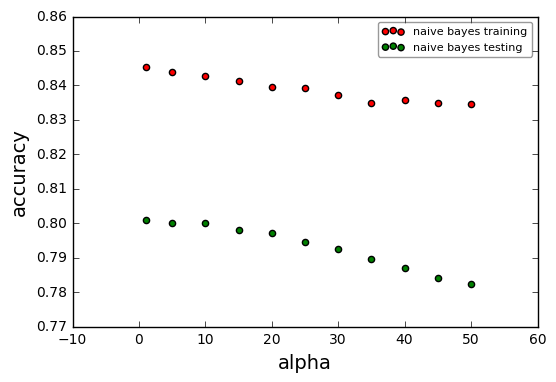

In [44]:
def naive_bayes_alpha(a, X_train, y_train, X_test, y_test):
    # Naive bayes
    clf = MultinomialNB(alpha = a)
    clf.fit(X_train, y_train)

    return clf.score(X_train, y_train), clf.score(X_test, y_test)

nb_alpha_trains = []
nb_alpha_tests = []


alphas = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
for a in alphas:
    nb_alpha_train, nb_alpha_test = naive_bayes_alpha(a, X_train, y_train, X_test, y_test)
    
    nb_alpha_trains.append(nb_alpha_train)
    nb_alpha_tests.append(nb_alpha_test)



plt.scatter(alphas, nb_alpha_trains, c='r', label='naive bayes training')
plt.scatter(alphas, nb_alpha_tests, c='g',label='naive bayes testing')

leg = plt.legend(loc=0,fancybox=True, fontsize=8)
leg.get_frame().set_alpha(0.4)

plt.xlabel('alpha', fontsize=14)
plt.ylabel('accuracy', fontsize=14)

plt.show()


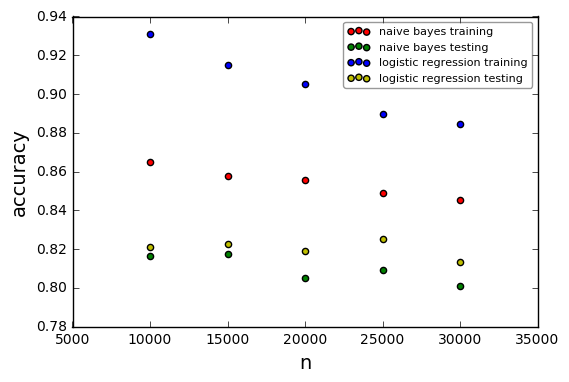

Strangly, in the example test and training accuracy seem to decrease as we increase the size of n


In [45]:
sizes = [10000, 15000, 20000, 25000, 30000]

nb_trains = [] 
nb_tests = []
log_trains = [] 
log_tests = []

for size in sizes:
    # number of examples to use for training
    n_train = size

    X_train, y_train = X[:n_train, :], y[:n_train]
    X_test, y_test = X[n_train:, :], y[n_train:]
    
    nb_train, nb_test = naive_bayes(X_train, y_train, X_test, y_test)
    nb_trains.append(nb_train)
    nb_tests.append(nb_test)
    
    log_train, log_test = logistic_regression(X_train, y_train, X_test, y_test)
    log_trains.append(log_train)
    log_tests.append(log_test)


plt.scatter(sizes, nb_trains, c='r', label='naive bayes training')
plt.scatter(sizes, nb_tests, c='g',label='naive bayes testing')

plt.scatter(sizes, log_trains, c='b', label='logistic regression training')
plt.scatter(sizes, log_tests, c='y',label='logistic regression testing')
leg = plt.legend(loc=0,fancybox=True, fontsize=8)
leg.get_frame().set_alpha(0.4)

plt.xlabel('n', fontsize=14)
plt.ylabel('accuracy', fontsize=14)

plt.show()
print 'Strangly, in the example test and training accuracy seem to decrease as we increase the size of n'